# Predict cause of WildFires in US
## Multi Class classification problem

In [2]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [3]:
# Create a SQL connection to SQLite database
cnx = sqlite3.connect('./data/FPA_FOD_20170508.sqlite')
df = pd.read_sql_query("SELECT FIRE_YEAR,STAT_CAUSE_DESCR,LATITUDE,LONGITUDE,STATE,DISCOVERY_DATE,FIRE_SIZE FROM 'Fires'", cnx)
df_orig = df.copy()
# Print number of rows in the Fires table
print(df.shape[0])

# close the connection
cnx.close()

1880465


## Analyze the column data - Check for nulls, Apply date formatting 

In [4]:
df.isnull().sum().sum()

0

In [4]:
df['DATE'] = pd.to_datetime(df['DISCOVERY_DATE'], unit='D', origin='julian')
df['MONTH'] = pd.DatetimeIndex(df['DATE']).month
# use formatting to get the day of week
df['DAY_OF_WEEK']  = df['DATE'].dt.day_name()
print(df.head())

   FIRE_YEAR STAT_CAUSE_DESCR   LATITUDE   LONGITUDE STATE  DISCOVERY_DATE  \
0       2005    Miscellaneous  40.036944 -121.005833    CA       2453403.5   
1       2004        Lightning  38.933056 -120.404444    CA       2453137.5   
2       2004   Debris Burning  38.984167 -120.735556    CA       2453156.5   
3       2004        Lightning  38.559167 -119.913333    CA       2453184.5   
4       2004        Lightning  38.559167 -119.933056    CA       2453184.5   

   FIRE_SIZE       DATE  MONTH DAY_OF_WEEK  
0       0.10 2005-02-02      2   Wednesday  
1       0.25 2004-05-12      5   Wednesday  
2       0.10 2004-05-31      5      Monday  
3       0.10 2004-06-28      6      Monday  
4       0.10 2004-06-28      6      Monday  


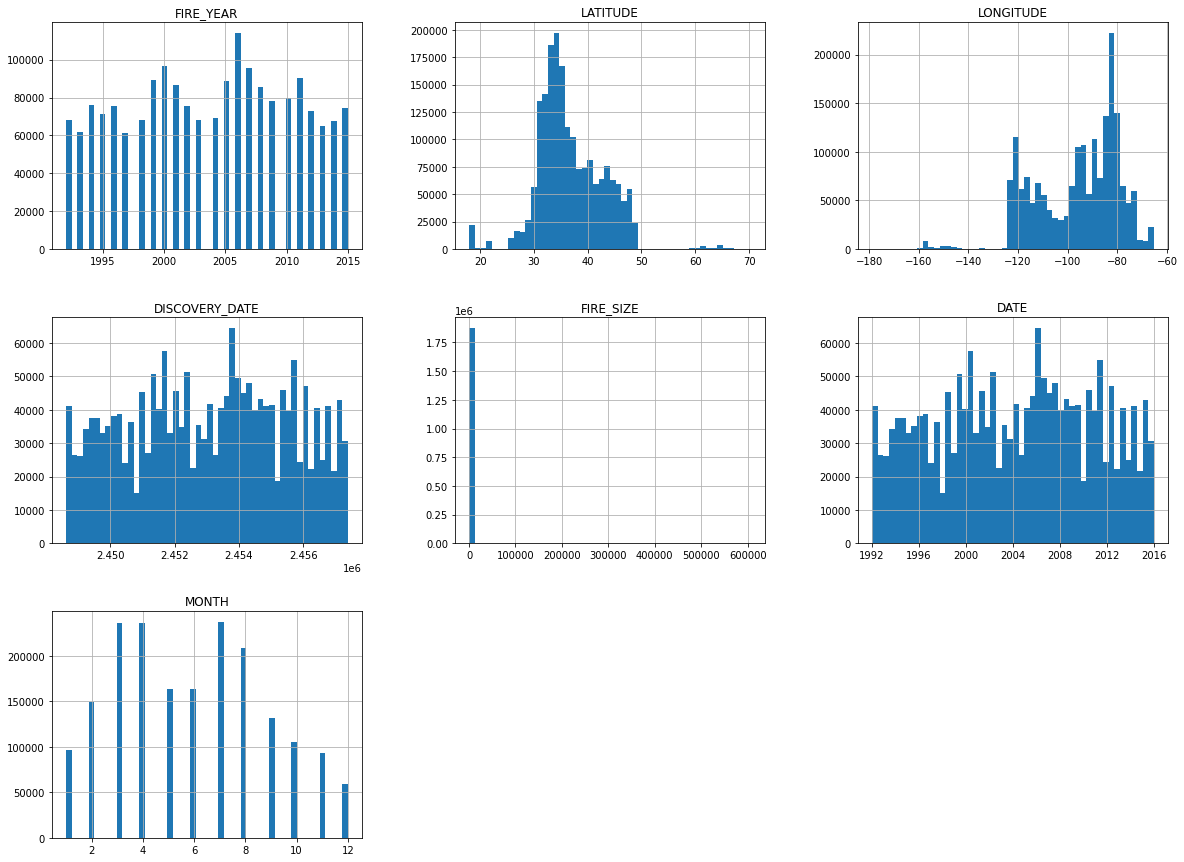

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
df.hist(bins=50, figsize=(20,15))
plt.show()

## Dependent Variable count by different classes

In [6]:
df['STAT_CAUSE_DESCR'].value_counts()

Debris Burning       429028
Miscellaneous        323805
Arson                281455
Lightning            278468
Missing/Undefined    166723
Equipment Use        147612
Campfire              76139
Children              61167
Smoking               52869
Railroad              33455
Powerline             14448
Fireworks             11500
Structure              3796
Name: STAT_CAUSE_DESCR, dtype: int64

## Reduce the number of classes

In [7]:
def assign_label(cat):
    cause = 0
    natural = ['Lightning']
    accidental = ['Structure','Fireworks','Powerline','Railroad','Smoking','Children','Campfire','Equipment Use','Debris Burning']
    malicious = ['Arson']
    other = ['Missing/Undefined','Miscellaneous']
    if cat in natural:
        cause = 1
    elif cat in accidental:
        cause = 2
    elif cat in malicious:
        cause = 3
    else:
        cause = 4
    return cause

df['LABEL'] = df['STAT_CAUSE_DESCR'].apply(lambda x: assign_label(x)) 
df = df.drop('STAT_CAUSE_DESCR',axis=1)
df['LABEL'].value_counts()

2    830014
4    490528
3    281455
1    278468
Name: LABEL, dtype: int64

<AxesSubplot:>

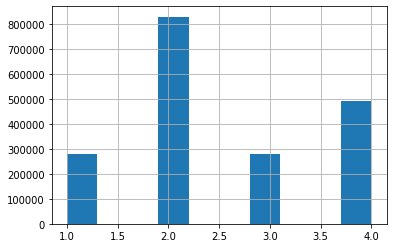

In [8]:
df["LABEL"].hist()

## Categorical Encoding using Frequency Encoding

In [9]:
fe = df.groupby('DAY_OF_WEEK').size()/len(df)
df.loc[:,'DAY_freq_encode']= df['DAY_OF_WEEK'].map(fe)
fe = df.groupby('MONTH').size()/len(df)
df.loc[:,'MONTH_freq_encode']= df['MONTH'].map(fe)
print(df.head())

   FIRE_YEAR   LATITUDE   LONGITUDE STATE  DISCOVERY_DATE  FIRE_SIZE  \
0       2005  40.036944 -121.005833    CA       2453403.5       0.10   
1       2004  38.933056 -120.404444    CA       2453137.5       0.25   
2       2004  38.984167 -120.735556    CA       2453156.5       0.10   
3       2004  38.559167 -119.913333    CA       2453184.5       0.10   
4       2004  38.559167 -119.933056    CA       2453184.5       0.10   

        DATE  MONTH DAY_OF_WEEK  LABEL  DAY_freq_encode  MONTH_freq_encode  
0 2005-02-02      2   Wednesday      4         0.137461           0.079311  
1 2004-05-12      5   Wednesday      1         0.137461           0.087158  
2 2004-05-31      5      Monday      2         0.144880           0.087158  
3 2004-06-28      6      Monday      1         0.144880           0.086915  
4 2004-06-28      6      Monday      1         0.144880           0.086915  


In [10]:
df = df.drop('DATE',axis=1)
df = df.drop('STATE',axis=1)
df = df.drop('DAY_OF_WEEK',axis=1)
print(df.head())

   FIRE_YEAR   LATITUDE   LONGITUDE  DISCOVERY_DATE  FIRE_SIZE  MONTH  LABEL  \
0       2005  40.036944 -121.005833       2453403.5       0.10      2      4   
1       2004  38.933056 -120.404444       2453137.5       0.25      5      1   
2       2004  38.984167 -120.735556       2453156.5       0.10      5      2   
3       2004  38.559167 -119.913333       2453184.5       0.10      6      1   
4       2004  38.559167 -119.933056       2453184.5       0.10      6      1   

   DAY_freq_encode  MONTH_freq_encode  
0         0.137461           0.079311  
1         0.137461           0.087158  
2         0.144880           0.087158  
3         0.144880           0.086915  
4         0.144880           0.086915  


## TRAIN TEST SPLIT

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import f1_score
import sklearn.ensemble as ske
from sklearn.model_selection import train_test_split

X = df.drop(['LABEL'], axis=1).values
y = df['LABEL'].values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=0) 

## Logistic Regression - OVR

In [13]:
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import roc_auc_score
clf = LogisticRegression(solver="lbfgs").fit(X_train, y_train)
roc_auc_score(y_test, clf.predict_proba(X_test), multi_class='ovr')

0.5099128298172424

## DecisionTree Classifier

In [18]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import confusion_matrix
import time

start_time = time.time()

dtree_model = DecisionTreeClassifier(max_depth = 9).fit(X_train, y_train) 
dtree_predictions = dtree_model.predict(X_test) 
  
print("execution time: %s" % time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time)))
# creating a confusion matrix 
conf_mx = confusion_matrix(y_test, dtree_predictions) 
conf_mx

execution time: 00:00:14


array([[ 59443,  17636,    944,   5293],
       [ 17095, 199990,  10764,  21479],
       [  2141,  55317,  17451,   9261],
       [ 12072,  69874,   4781,  60599]], dtype=int64)

## KNeighborsClassifier

In [19]:
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import f1_score

start_time = time.time()

knn = KNeighborsClassifier()
knn.fit(X_train, y_train) 
knn_predictions = knn.predict(X_test) 
y_train_pred = cross_val_predict(knn,X_train,y_train,cv=10 )
f1_score(y_train,y_train_pred,average="weighted")
print("execution time: %s" % time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time)))

execution time: 00:11:53


## RandomForest Classifier

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import time
import pandas as pd
import numpy as np

start_time = time.time()
rnd_clf = RandomForestClassifier(random_state=42)
rnd_clf.fit(X_train, y_train)
y_pred = rnd_clf.predict(X_test)

print("execution time: %s" % time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time)))

print(rnd_clf.score(X_test,y_test))
print(accuracy_score(y_test,y_pred))
print(rnd_clf.feature_importances_)
print(df.columns)

execution time: 00:18:17
0.6908497890594534
0.6908497890594534
[0.0489302  0.2653875  0.31082705 0.14912023 0.10169662 0.03420065
 0.06150836 0.02832939]
Index(['FIRE_YEAR', 'LATITUDE', 'LONGITUDE', 'DISCOVERY_DATE', 'FIRE_SIZE',
       'MONTH', 'LABEL', 'DAY_freq_encode', 'MONTH_freq_encode'],
      dtype='object')


## XGBoost


In [34]:
import time


In [35]:
import xgboost

In [36]:
import xgboost as xgb

In [14]:
import xgboost as xgb
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)
D_train = xgb.DMatrix(X_train, label=Y_train)
D_test = xgb.DMatrix(X_test, label=Y_test)
param = {
    'eta': 0.3, 
    'max_depth': 20,  
    'objective': 'multi:softprob',  
    'num_class': 5} 

steps = 20
model = xgb.train(param, D_train, steps)
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score

preds = model.predict(D_test)
best_preds = np.asarray([np.argmax(line) for line in preds])

print("Precision = {}".format(precision_score(Y_test, best_preds, average='macro')))
print("Recall = {}".format(recall_score(Y_test, best_preds, average='macro')))
print("Accuracy = {}".format(accuracy_score(Y_test, best_preds)))



[18:24:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Precision = 0.7195431799448723
Recall = 0.6816984584949299
Accuracy = 0.7123769918610556


## Drop Fire_size column and run model

In [17]:
df = df.drop('FIRE_SIZE',axis=1)
print(df.head())

   FIRE_YEAR   LATITUDE   LONGITUDE  DISCOVERY_DATE  MONTH  LABEL  \
0       2005  40.036944 -121.005833       2453403.5      2      4   
1       2004  38.933056 -120.404444       2453137.5      5      1   
2       2004  38.984167 -120.735556       2453156.5      5      2   
3       2004  38.559167 -119.913333       2453184.5      6      1   
4       2004  38.559167 -119.933056       2453184.5      6      1   

   DAY_freq_encode  MONTH_freq_encode  
0         0.137461           0.079311  
1         0.137461           0.087158  
2         0.144880           0.087158  
3         0.144880           0.086915  
4         0.144880           0.086915  


In [18]:
X = df.drop(['LABEL'], axis=1).values
y = df['LABEL'].values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=0)

In [19]:
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import roc_auc_score
clf = LogisticRegression(solver="lbfgs").fit(X_train, y_train)
roc_auc_score(y_test, clf.predict_proba(X_test), multi_class='ovr')

0.49945805046623215

In [20]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import confusion_matrix

dtree_model = DecisionTreeClassifier(max_depth = 9).fit(X_train, y_train) 
dtree_predictions = dtree_model.predict(X_test) 
  
# creating a confusion matrix 
conf_mx = confusion_matrix(y_test, dtree_predictions) 
conf_mx

array([[ 59046,  19128,    490,   4652],
       [ 15996, 206211,   9596,  17525],
       [  1936,  58517,  16373,   7344],
       [ 11804,  73290,   3073,  59159]], dtype=int64)

## Reduce number of classes to 3 instead of 4 and see if it improves score

In [21]:
df = df_orig
print(df.head())

   FIRE_YEAR STAT_CAUSE_DESCR   LATITUDE   LONGITUDE STATE  DISCOVERY_DATE  \
0       2005    Miscellaneous  40.036944 -121.005833    CA       2453403.5   
1       2004        Lightning  38.933056 -120.404444    CA       2453137.5   
2       2004   Debris Burning  38.984167 -120.735556    CA       2453156.5   
3       2004        Lightning  38.559167 -119.913333    CA       2453184.5   
4       2004        Lightning  38.559167 -119.933056    CA       2453184.5   

   FIRE_SIZE  
0       0.10  
1       0.25  
2       0.10  
3       0.10  
4       0.10  


In [22]:
df['DATE'] = pd.to_datetime(df['DISCOVERY_DATE'], unit='D', origin='julian')
df['MONTH'] = pd.DatetimeIndex(df['DATE']).month
# use formatting to get the day of week
df['DAY_OF_WEEK']  = df['DATE'].dt.day_name()

In [23]:
def set_label(cat):
    cause = 0
    natural = ['Lightning']
    accidental = ['Structure','Fireworks','Powerline','Railroad','Smoking','Children','Campfire','Equipment Use','Debris Burning']
    malicious = ['Arson']
    other = ['Missing/Undefined','Miscellaneous']
    if cat in natural:
        cause = 1
    elif cat in accidental:
        cause = 2
    elif cat in malicious:
        cause = 3
    else:
        cause = 2
    return cause

df['LABEL'] = df['STAT_CAUSE_DESCR'].apply(lambda x: set_label(x)) 
df= df.drop('STAT_CAUSE_DESCR',axis=1)

In [24]:
from sklearn import tree, preprocessing
le = preprocessing.LabelEncoder()
df['DAY_OF_WEEK'] = le.fit_transform(df['DAY_OF_WEEK'])

In [25]:
df = df.drop('STATE',axis=1)
df = df.drop('DATE',axis=1)
print(df.head())


   FIRE_YEAR   LATITUDE   LONGITUDE  DISCOVERY_DATE  FIRE_SIZE  MONTH  \
0       2005  40.036944 -121.005833       2453403.5       0.10      2   
1       2004  38.933056 -120.404444       2453137.5       0.25      5   
2       2004  38.984167 -120.735556       2453156.5       0.10      5   
3       2004  38.559167 -119.913333       2453184.5       0.10      6   
4       2004  38.559167 -119.933056       2453184.5       0.10      6   

   DAY_OF_WEEK  LABEL  
0            6      2  
1            6      1  
2            1      2  
3            1      1  
4            1      1  


In [26]:
df = df.drop('FIRE_SIZE',axis=1)

In [27]:
df['LABEL'].value_counts()

2    1320542
3     281455
1     278468
Name: LABEL, dtype: int64

In [29]:
X = df.drop(['LABEL'], axis=1).values
y = df['LABEL'].values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=0)
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import roc_auc_score
clf = LogisticRegression(solver="lbfgs").fit(X_train, y_train)
roc_auc_score(y_test, clf.predict_proba(X_test), multi_class='ovr')

0.6627030036354392

In [30]:
rnd_clf = RandomForestClassifier(random_state=42)
rnd_clf.fit(X_train, y_train)
y_pred = rnd_clf.predict(X_test)
print(rnd_clf.score(X_test,y_test))
print(accuracy_score(y_test,y_pred))1

0.8322100896940475
0.8322100896940475


## Xgboost with GridSearchCV

In [31]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import time
import pandas as pd
import numpy as np

X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

#################################################################
# Pipeline
#################################################################
params = {
    'max_depth': 6,
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': 4,
    'n_gpus': 0
}
pipe_xgb = Pipeline([
    ('clf', xgb.XGBClassifier(**params))
    ])

parameters_xgb = {
        'clf__n_estimators':[30,40]
    }

grid_xgb = GridSearchCV(pipe_xgb,
    param_grid=parameters_xgb,
    scoring='accuracy',
    cv=5,
    refit=True)


start_time = time.time()

grid_xgb.fit(X_train, y_train)

acc = grid_xgb.score(X_valid,y_valid)

print("Best params                        : %s" % grid_xgb.best_params_)
print("Best training data accuracy        : %s" % grid_xgb.best_score_)    
print("Best validation data accuracy (*)  : %s" % acc)
print("Modeling time                      : %s" % time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time)))

#Predict using the test data with selected features
y_pred = grid_xgb.predict(X_valid)

accuracy_score(y_valid, y_pred)

[20:01:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:03:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:04:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:06:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

0.7822985272259787

# SMOTE - Synthetic Minority Oversampling Technique

In [33]:
# decision tree evaluated on imbalanced dataset with SMOTE oversampling
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

# define pipeline
steps = [('over', SMOTE()), ('model', DecisionTreeClassifier())]
pipeline = Pipeline(steps=steps)
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: nan


## The result is "nan" because scoring parameter with value 'roc_auc' is for binary classification. Since I have multi class classification it needs to be scoring='f1_micro' as below and it evaluated a proper score.

In [34]:
print(df.head())

   FIRE_YEAR   LATITUDE   LONGITUDE  DISCOVERY_DATE  MONTH  DAY_OF_WEEK  LABEL
0       2005  40.036944 -121.005833       2453403.5      2            6      2
1       2004  38.933056 -120.404444       2453137.5      5            6      1
2       2004  38.984167 -120.735556       2453156.5      5            1      2
3       2004  38.559167 -119.913333       2453184.5      6            1      1
4       2004  38.559167 -119.933056       2453184.5      6            1      1


In [35]:
# Create a SQL connection to SQLite database
cnx = sqlite3.connect('./data/FPA_FOD_20170508.sqlite')
df = pd.read_sql_query("SELECT FIRE_YEAR,STAT_CAUSE_DESCR,LATITUDE,LONGITUDE,STATE,DISCOVERY_DATE,FIRE_SIZE FROM 'Fires'", cnx)

# Print number of rows in the Fires table
print(df.shape[0])

# close the connection
cnx.close()

1880465


In [36]:
df['DATE'] = pd.to_datetime(df['DISCOVERY_DATE'], unit='D', origin='julian')
df['MONTH'] = pd.DatetimeIndex(df['DATE']).month
# use formatting to get the day of week
df['DAY_OF_WEEK']  = df['DATE'].dt.day_name()

## Reduce the dataset to only Fires in CA and test out the SMOTE

In [37]:
df_CA = df[df['STATE']=='CA']

In [38]:
df_CA= df_CA.drop('STATE',axis=1)
df_CA= df_CA.drop('DATE',axis=1)

In [39]:
def set_label(cat):
    cause = 0
    natural = ['Lightning']
    accidental = ['Structure','Fireworks','Powerline','Railroad','Smoking','Children','Campfire','Equipment Use','Debris Burning']
    malicious = ['Arson']
    other = ['Missing/Undefined','Miscellaneous']
    if cat in natural:
        cause = 1
    elif cat in accidental:
        cause = 2
    elif cat in malicious:
        cause = 3
    else:
        cause = 2
    return cause

df_CA['LABEL'] = df_CA['STAT_CAUSE_DESCR'].apply(lambda x: set_label(x)) 
df_CA= df_CA.drop('STAT_CAUSE_DESCR',axis=1)

In [40]:
from sklearn import tree, preprocessing
le = preprocessing.LabelEncoder()
df_CA['DAY_OF_WEEK'] = le.fit_transform(df_CA['DAY_OF_WEEK'])
print(df_CA.head())

   FIRE_YEAR   LATITUDE   LONGITUDE  DISCOVERY_DATE  FIRE_SIZE  MONTH  \
0       2005  40.036944 -121.005833       2453403.5       0.10      2   
1       2004  38.933056 -120.404444       2453137.5       0.25      5   
2       2004  38.984167 -120.735556       2453156.5       0.10      5   
3       2004  38.559167 -119.913333       2453184.5       0.10      6   
4       2004  38.559167 -119.933056       2453184.5       0.10      6   

   DAY_OF_WEEK  LABEL  
0            6      2  
1            6      1  
2            1      2  
3            1      1  
4            1      1  


In [41]:
df_CA['LABEL'].value_counts()

2    142915
1     27000
3     19635
Name: LABEL, dtype: int64

In [42]:
import sklearn.ensemble as ske
from sklearn.model_selection import train_test_split
X = df_CA.drop(['LABEL'], axis=1).values
y = df_CA['LABEL'].values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42)

## Print out the dependent variable count before and after SMOTE

In [64]:
from collections import Counter
counter = Counter(y_train)
print(counter)
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)
counter = Counter(y_train)
print(counter)

Counter({2: 99997, 1: 18980, 3: 13708})
Counter({1: 99997, 2: 99997, 3: 99997})


In [45]:
y_train.shape

(299991,)

In [46]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import confusion_matrix

dtree_model = DecisionTreeClassifier(max_depth = 9).fit(X_train, y_train) 
dtree_predictions = dtree_model.predict(X_test) 
  
# creating a confusion matrix 
conf_mx = confusion_matrix(y_test, dtree_predictions) 
conf_mx

array([[ 6244,   870,   906],
       [ 5356, 29040,  8522],
       [  525,  2815,  2587]], dtype=int64)

In [67]:
import sklearn.ensemble as ske
from sklearn.model_selection import train_test_split
df_CA.dropna()
X = df_CA.drop(['LABEL'], axis=1).values
y = df_CA['LABEL'].values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42)

In [69]:
from collections import Counter
counter = Counter(y_train)
print(counter)
oversample = SMOTE()
X_train2, y_train2 = oversample.fit_resample(X_train, y_train)
from collections import Counter
counter = Counter(y_train2)
print(counter)

Counter({2: 99997, 1: 18980, 3: 13708})
Counter({1: 99997, 2: 99997, 3: 99997})


In [80]:
model = DecisionTreeClassifier(max_depth = 9)
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=42)
scores = cross_val_score(model, X_train2, y_train2,scoring='f1_micro',cv=cv)
##print(scores)
print(cv)
print('F1 micro: %.3f' % mean(scores))

RepeatedStratifiedKFold(n_repeats=3, n_splits=3, random_state=42)
F1 micro: 0.712


In [70]:
print(X_train[:10],X_train2[:10])

[[ 1.99200000e+03  4.18183333e+01 -1.20685000e+02  2.44884750e+06
   2.00000000e+00  8.00000000e+00  4.00000000e+00]
 [ 2.01100000e+03  3.46822000e+01 -1.18194700e+02  2.45573950e+06
   1.10000000e-01  6.00000000e+00  1.00000000e+00]
 [ 2.00300000e+03  3.69411111e+01 -1.19188056e+02  2.45298450e+06
   1.00000000e-01  1.20000000e+01  4.00000000e+00]
 [ 2.00600000e+03  4.17661111e+01 -1.22681111e+02  2.45394050e+06
   1.00000000e-01  7.00000000e+00  1.00000000e+00]
 [ 1.99400000e+03  4.14011111e+01 -1.22371111e+02  2.44956050e+06
   1.30000000e+00  7.00000000e+00  6.00000000e+00]
 [ 2.00400000e+03  3.36488889e+01 -1.17215000e+02  2.45313050e+06
   1.00000000e+00  5.00000000e+00  6.00000000e+00]
 [ 2.00400000e+03  4.17697222e+01 -1.22818889e+02  2.45321050e+06
   1.00000000e-01  7.00000000e+00  2.00000000e+00]
 [ 2.00400000e+03  3.51022220e+01 -1.18490472e+02  2.45318050e+06
   1.50000000e+01  6.00000000e+00  4.00000000e+00]
 [ 1.99200000e+03  3.39538889e+01 -1.17163889e+02  2.44889250e+0

In [55]:
print(df_CA.shape[0])

189550


In [56]:
print(df_CA.head())

   FIRE_YEAR   LATITUDE   LONGITUDE  DISCOVERY_DATE  FIRE_SIZE  MONTH  \
0       2005  40.036944 -121.005833       2453403.5       0.10      2   
1       2004  38.933056 -120.404444       2453137.5       0.25      5   
2       2004  38.984167 -120.735556       2453156.5       0.10      5   
3       2004  38.559167 -119.913333       2453184.5       0.10      6   
4       2004  38.559167 -119.933056       2453184.5       0.10      6   

   DAY_OF_WEEK  LABEL  
0            6      2  
1            6      1  
2            1      2  
3            1      1  
4            1      1  


In [57]:
df_CA["LABEL"].value_counts()

2    142915
1     27000
3     19635
Name: LABEL, dtype: int64

In [62]:
from collections import Counter
counter = Counter(y_train)
print(counter)

Counter({1: 99997, 2: 99997, 3: 99997})


In [72]:
import seaborn as sns



<AxesSubplot:ylabel='Density'>

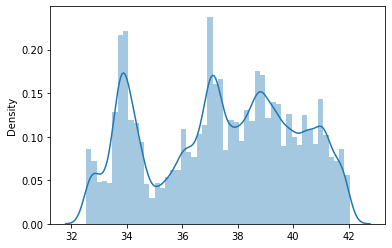

In [74]:
sns.distplot(X_train[:,1], kde=True)

<AxesSubplot:ylabel='Density'>

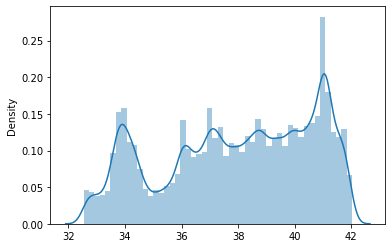

In [75]:
sns.distplot(X_train2[:,1], kde=True)